# Предсказване на цените на диаманти по техните характеристики

In [1]:
import sys
import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

Използвам данни от https://www.kaggle.com/shivam2503/diamonds

In [2]:
original = pd.read_csv('data/diamonds/diamonds.csv', index_col=[0])
data = original.copy()

data.shape

(53940, 10)

In [3]:
from sklearn.model_selection import train_test_split

X = data.drop('price', 1)
y = data['price']
train, test, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state=1564)

Разглеждам какво съдържат данните

In [4]:

train.head(10)

,carat,cut,color,clarity,depth,table,x,y,z
48219,0.53,Ideal,H,IF,62.0,54.0,5.22,5.27,3.25
42858,0.54,Premium,G,SI1,60.8,59.0,5.27,5.23,3.19
22191,1.51,Very Good,H,VS2,62.8,58.0,7.21,7.28,4.55
33074,0.32,Ideal,H,IF,62.1,54.0,4.41,4.45,2.75
39773,0.50,Very Good,F,SI2,63.5,58.0,5.03,4.98,3.18
9160,1.01,Very Good,E,SI2,60.0,60.0,6.57,6.49,3.92
33880,0.30,Premium,E,VS2,60.7,59.0,4.33,4.30,2.62
21291,1.13,Ideal,D,VS1,61.4,55.0,6.72,6.74,4.13
51809,0.72,Ideal,E,SI1,60.9,57.0,5.83,5.86,3.56
25480,2.27,Good,H,SI2,63.6,58.0,8.37,8.29,5.30


Някои атрибути са с числови стойности, а други съдържат стрингове.

In [5]:
train.describe()

,carat,depth,table,x,y,z
count,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000
mean,0.797900,61.745532,57.465557,5.731215,5.734515,3.538706
std,0.473846,1.432256,2.238938,1.121243,1.141913,0.708254
min,0.200000,43.000000,43.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,4.720000,4.730000,2.910000
50%,0.700000,61.800000,57.000000,5.700000,5.710000,3.520000
75%,1.040000,62.500000,59.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,10.740000,58.900000,31.800000


Проверявам за null стойности.

In [6]:
train.isnull().sum().sort_values()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
dtype: int64

Няма null стойности в данните.

Ще пусна линейна регресия само по числовите данни, за да пробвам какво ще стане. За тестване и оптимизиране на модела ще разделя и тренировъчните данни.

In [7]:
from sklearn.linear_model import LinearRegression

X = train[['carat', 'depth', 'table', 'x', 'y', 'z']]
y = train_y

x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=4330)

regressor = LinearRegression()
regressor.fit(x_train, y_train)
print(regressor.score(x_train, y_train))
print(regressor.score(x_test, y_test))

0.8597416952
0.853380738406


Получавам доста добри резултати като зa начало. 
Ще разгледам графика на получената функция, сравнена с реалните цени.

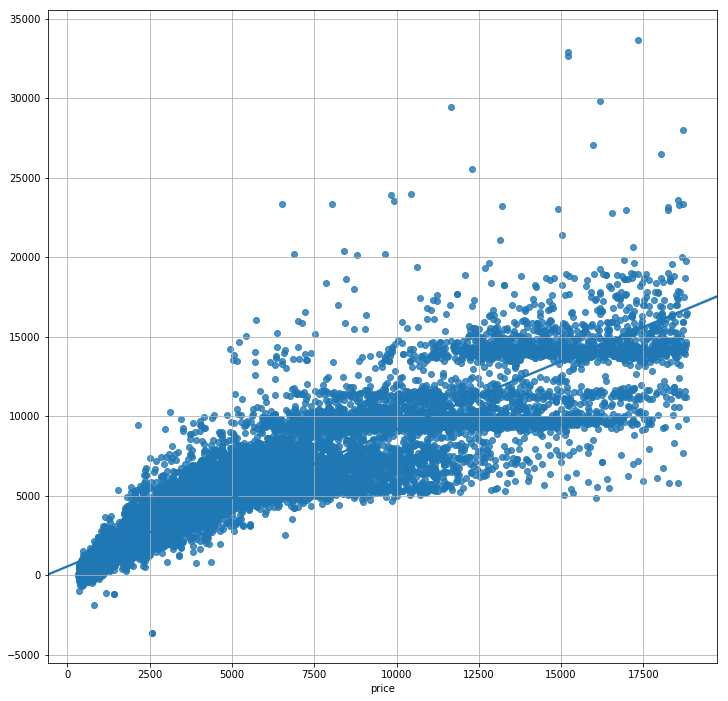

In [8]:
predictions = regressor.predict(x_train)

plt.figure(figsize=(12,12))
sns.regplot(y_train, predictions)
plt.grid(True)
plt.show()

Цените нарастват сравнително линейно и функцията минава долу горе през средата, но има точки, които остават доста далеч от нея

Резултатът е добър, но не достатъчно. Ще трябва да включа и другите атрибути, но трябва да ги преработя.
Първо ще разгледам всеки от тях поотделно.

"cut" показва качеството на шлифоване на диаманта.
Има 5 възможни стойности - Ideal, Premium, Very Good, Good, Fair (подредени са в низходящ ред на качеството).
Ще изведа барплот, за да видя колко пъти се среща всяка от стойностите.

Ideal        17228
Premium      11002
Very Good     9689
Good          3959
Fair          1274
Name: cut, dtype: int64


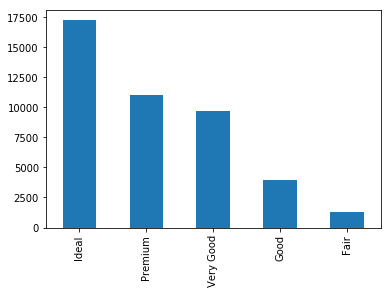

In [9]:
print(train.cut.value_counts())
train.cut.value_counts().plot(kind='bar');

"color" показва оцветяването на диамантите. Възможните стойности са (най-добър) D, E, F....J (най-лош)

G    9052
E    7887
F    7667
H    6625
D    5444
I    4271
J    2206
Name: color, dtype: int64


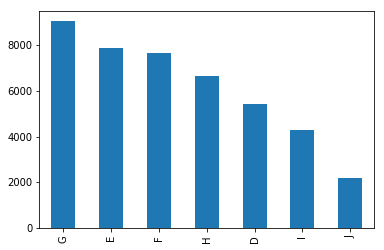

In [10]:
print(train.color.value_counts())
train.color.value_counts().plot(kind='bar');

"clarity" е мярка за чистотата на диаманта. Стойностите са I1 (най-лошо), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (най-добро), подредени във възходящ ред.

SI1     10500
VS2      9787
SI2      7316
VS1      6520
VVS2     4104
VVS1     2911
IF       1432
I1        582
Name: clarity, dtype: int64


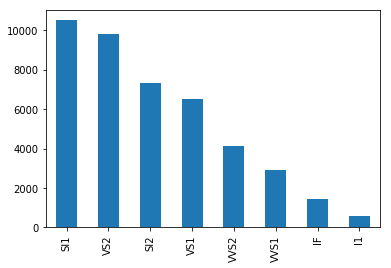

In [11]:
print(train.clarity.value_counts())
train.clarity.value_counts().plot(kind='bar');

Тъй като стойностите в cut, color и  clarity са краен брой и те могат да бъдат подредени в нарастващ ред според качеството, ще пробвам да ги преобразувам в числа според качеството(по-голямо число -> по-добро-качество на тази характеристика).

In [12]:
data1=train.copy()
data1.cut.replace(['Ideal', 'Premium', 'Very Good', 'Good', 'Fair'], [5, 4, 3, 2, 1], inplace = True)
data1.color.replace(['D', 'E', 'F', 'G', 'H', 'I', 'J'], [7, 6, 5, 4, 3, 2, 1], inplace = True)
data1.clarity.replace(['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'], [1, 2, 3, 4, 5, 6, 7, 8], inplace = True)

X = data1
y = train_y
X.head(10)

,carat,cut,color,clarity,depth,table,x,y,z
48219,0.53,5,3,8,62.0,54.0,5.22,5.27,3.25
42858,0.54,4,4,3,60.8,59.0,5.27,5.23,3.19
22191,1.51,3,3,4,62.8,58.0,7.21,7.28,4.55
33074,0.32,5,3,8,62.1,54.0,4.41,4.45,2.75
39773,0.50,3,5,2,63.5,58.0,5.03,4.98,3.18
9160,1.01,3,6,2,60.0,60.0,6.57,6.49,3.92
33880,0.30,4,6,4,60.7,59.0,4.33,4.30,2.62
21291,1.13,5,7,5,61.4,55.0,6.72,6.74,4.13
51809,0.72,5,6,3,60.9,57.0,5.83,5.86,3.56
25480,2.27,2,3,2,63.6,58.0,8.37,8.29,5.30


Тренирам модела и извеждам резултатите.

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=4330)
regressor = LinearRegression()
regressor.fit(x_train, y_train)
print(regressor.score(x_train, y_train))
print(regressor.score(x_test, y_test))

0.907358266703
0.902494728647


Резултатът е доста по-добър от предишния. Train score и test score са близки(няма овърфитване).

Ще пробвам да нормализирам данните.

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train)


x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

regressor = LinearRegression()
regressor.fit(x_train_scaled, y_train)

print(regressor.score(x_train_scaled, y_train))
print(regressor.score(x_test_scaled, y_test))

0.907358266703
0.902494728647


Няма разлика.

Сега ще пробвам да отделя колона за всяка една от стойностите в cut, color и clarity.

Ще си направя функция за по-лесно.

In [15]:
def encode(data, column, categories):
    for c in categories:
        data[c] = (column == c).astype(float)


data = train.copy()        
encode(data, data.cut, data.cut.unique())
encode(data, data.color, data.color.unique())
encode(data, data.clarity, data.clarity.unique())

data.head(10)

,carat,cut,color,clarity,depth,table,x,y,z,Ideal,...,I,J,IF,SI1,VS2,SI2,VS1,VVS2,VVS1,I1
48219,0.53,Ideal,H,IF,62.0,54.0,5.22,5.27,3.25,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42858,0.54,Premium,G,SI1,60.8,59.0,5.27,5.23,3.19,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
22191,1.51,Very Good,H,VS2,62.8,58.0,7.21,7.28,4.55,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
33074,0.32,Ideal,H,IF,62.1,54.0,4.41,4.45,2.75,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39773,0.50,Very Good,F,SI2,63.5,58.0,5.03,4.98,3.18,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9160,1.01,Very Good,E,SI2,60.0,60.0,6.57,6.49,3.92,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
33880,0.30,Premium,E,VS2,60.7,59.0,4.33,4.30,2.62,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
21291,1.13,Ideal,D,VS1,61.4,55.0,6.72,6.74,4.13,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
51809,0.72,Ideal,E,SI1,60.9,57.0,5.83,5.86,3.56,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25480,2.27,Good,H,SI2,63.6,58.0,8.37,8.29,5.30,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Отново ще пробвам с линейна регресия след като добавих новите колони.

In [16]:
X = data.drop(['cut', 'color', 'clarity'], 1)
y = train_y

x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=4330)

regressor = LinearRegression()
regressor.fit(x_train, y_train)
print(regressor.score(x_train, y_train))
print(regressor.score(x_test, y_test))

0.920198168923
0.915641064498


Скорът е по-добър.

Забелязвам, че depth е функция на x, y, z. Ще пробвам какво ще стане , ако премахна зависимите колони.
Трябва да махна x, y и z или depth.

In [17]:
X = data.drop(['cut', 'color', 'clarity', 'x', 'y', 'z'], 1)
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=4330)
regressor = LinearRegression()
regressor.fit(x_train, y_train)
print(regressor.score(x_train, y_train))
print(regressor.score(x_test, y_test))

0.916189504896
0.913655470942


In [18]:
X = data.drop(['cut', 'color', 'clarity', 'depth'], 1)
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=4330)
regressor = LinearRegression()
regressor.fit(x_train, y_train)
print(regressor.score(x_train, y_train))
print(regressor.score(x_test, y_test))

0.919967070058
0.914935504742


Резултатите са малко по-лоши.

Ще опитам да променя хиперпараметъра алфа.

In [19]:
from sklearn.linear_model import Ridge

X = data.drop(['cut', 'color', 'clarity'], 1)
y = train_y

x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=4330)

alpha = [0.01, 0.1, 1, 10, 100]

for a in alpha:
    all_data_lr = Ridge(alpha = a).fit(x_train, y_train)
    print('alpha:', a)
    print(all_data_lr.score(x_train, y_train), all_data_lr.score(x_test, y_test))
    print()

alpha: 0.01
0.920198168819 0.91564141104

alpha: 0.1
0.920198158533 0.91564451915

alpha: 1
0.920197136779 0.915674541483

alpha: 10
0.920101439557 0.91587629093

alpha: 100
0.914568824134 0.912488875987



Няма голяма разлика в резултата. Избирам алфа = 10.

Ще изведа графика на функцията, сравнена с реалните цени.

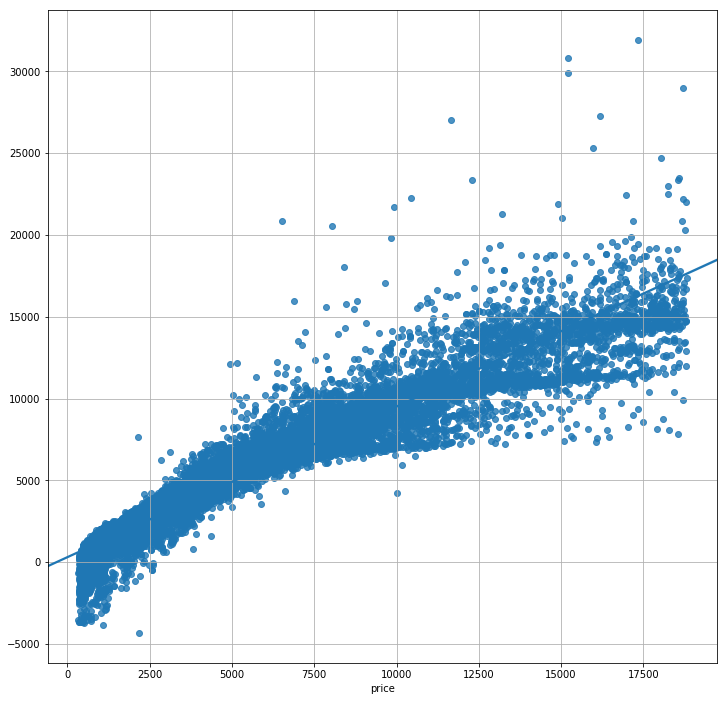

In [20]:
regressor = LinearRegression(10)
regressor.fit(x_train, y_train)
predictions = regressor.predict(x_train)

plt.figure(figsize=(12,12))
sns.regplot(y_train, predictions)
plt.grid(True)
plt.show()

 Има доста точки далеч от линията. При нарастване на цената точките все повече се раздалечават. Може би линейната регресия не е най-подходяща за този случай. Ще пробвам с k nearest neighbors.
 За наго ще използвам data1, където данните са само label encoded.

In [21]:
from sklearn.neighbors import KNeighborsRegressor

X = data1
y = train_y

x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=4330)

regressor = KNeighborsRegressor()
regressor.fit(x_train, y_train)
print(regressor.score(x_train, y_train))
print(regressor.score(x_test, y_test))

0.966294079196
0.950473169751


Получавам по-добър резултат. По подразбиране к=5. Ще пробвам да променя броя на съседите, които се взимат предвид.
Ще използвам GridSearch.

In [22]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(KNeighborsRegressor(),{'n_neighbors':[2,3,4,5,6,7,8,9,10]})
gs.fit(x_train, y_train)
pd.DataFrame(gs.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

,rank_test_score,mean_test_score,params
6,1,0.945525,{'n_neighbors': 8}
7,2,0.945303,{'n_neighbors': 9}
4,3,0.945222,{'n_neighbors': 6}
5,4,0.945218,{'n_neighbors': 7}
8,5,0.945093,{'n_neighbors': 10}
3,6,0.944548,{'n_neighbors': 5}
2,7,0.942500,{'n_neighbors': 4}
1,8,0.939803,{'n_neighbors': 3}
0,9,0.932227,{'n_neighbors': 2}


Получавам най-добър резултат при к=8.

In [23]:
regressor = KNeighborsRegressor(8)
regressor.fit(x_train, y_train)
print(regressor.score(x_train, y_train))
print(regressor.score(x_test, y_test))

0.961728763404
0.952231229178


Ще пробвам да подобря резултата като нормализирам данните.

In [24]:
scaler = StandardScaler().fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

regressor = KNeighborsRegressor(8)
regressor.fit(x_train_scaled, y_train)
print(regressor.score(x_train_scaled, y_train))
print(regressor.score(x_test_scaled, y_test))

0.973383727668
0.966758283016


Има малко подобрение. Ще опитам с weights='distance'.

In [25]:
regressor = KNeighborsRegressor(n_neighbors=8, weights='distance')
regressor.fit(x_train_scaled, y_train)
print(regressor.score(x_train_scaled, y_train))
print(regressor.score(x_test_scaled, y_test))

0.999998499548
0.968958718313


Получавам много добър резултат за тренировъчните данни. Може би леко овърфитва.

Ще събера трансформациите в една функция и ще я приложа към всички данни.
Ще тренирам модела с целия трейн сет и ще пробвам с тестовите данни, които модела вижда за пръв път.

In [26]:
def transform(data1):
    data1.cut.replace(['Ideal', 'Premium', 'Very Good', 'Good', 'Fair'], [5, 4, 3, 2, 1], inplace = True)
    data1.color.replace(['D', 'E', 'F', 'G', 'H', 'I', 'J'], [7, 6, 5, 4, 3, 2, 1], inplace = True)
    data1.clarity.replace(['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'], [1, 2, 3, 4, 5, 6, 7, 8], inplace = True)
    scaler = StandardScaler().fit(data1)
    data1 = scaler.transform(data1)
    return data1

x_train = transform(train.copy())
x_test = transform(test.copy())

regressor = KNeighborsRegressor(n_neighbors=8, weights='distance')
regressor.fit(x_train, train_y)
print(regressor.score(x_train, train_y))
print(regressor.score(x_test, test_y))


0.999995973036
0.97107440139


Добър резултат на тестовите данни. Не е много по-нисък от резултата на трениращите данни.
Ще изведа предсказанията и реалните цени за да видя какво се е получило.

In [27]:
predictions = regressor.predict(x_test)
frame = pd.DataFrame({
    'Predictions': predictions,
    'Prices': test_y
})

frame.head(10)

,Predictions,Prices
11441,5060.611142,5005
26737,16073.509656,16513
20538,9742.540218,8858
3775,3550.058131,3460
46278,1689.616736,1754
7927,4127.225431,4317
11266,6394.176245,4969
36691,932.806667,951
38409,792.079474,1024
4165,3644.715025,3552


На пръв поглед цените изглеждат доста близки. 
Ще визуализирам данните, за да съпоставя предсказаните стойности на реалните.

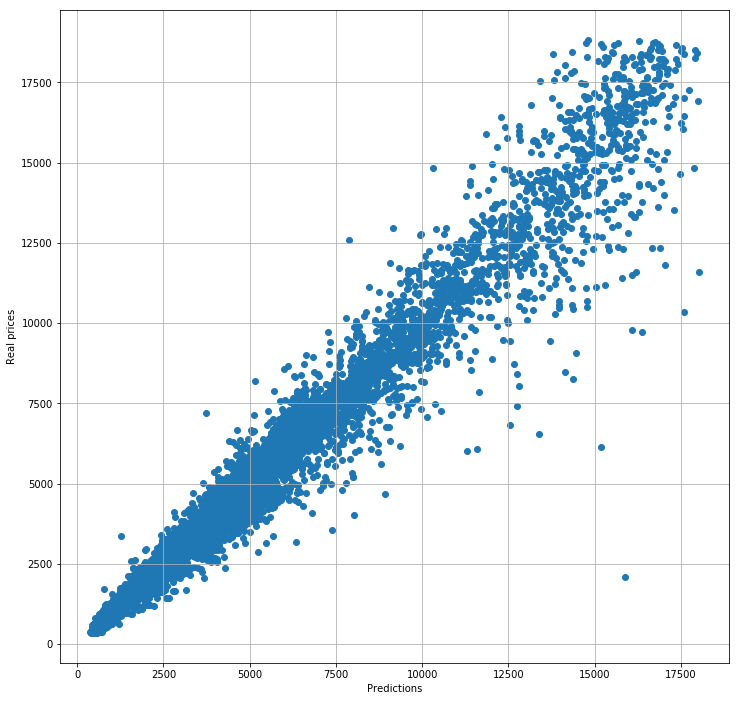

In [28]:
plt.figure(figsize=(12,12))
plt.grid(True)

plt.scatter(x=frame.Predictions, y=frame.Prices)
plt.xlabel("Predictions")
plt.ylabel("Real prices")

plt.show()


От графиката се вижда, че много голяма част от точките са близо до диагонала, което означава, че реалните и предсказаните цени са много близки. Има и точки, кито са доста далеч от диагонала, но те са единични. Обикновено при тези точки моделът предсказва доста по-ниска цена от реалната. 
Като цяло при по-ниските цени моделът е по-точен от колкото при по-скъпите диаманти.

За съжаление няма състезание с тези данни в kaggle и не мога да пробвам резултата там.